# DTW-SOM Evaluation - experiment with the GunPoint dataset

## 1. Packadge import

In [1]:
import os
import csv
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyclustering.nnet.som import type_conn
from matrixprofile import matrixProfile, motifs
# local code
import sys
sys.path.insert(0, os.path.abspath('../src'))
import dtw_som

## 2. Preprare the GunPoint dataset

Load the dataset:

In [2]:
ucr_data_folder = os.path.abspath("../../data-ucr-archive")
file = os.path.join(ucr_data_folder, "GunPoint", "GunPoint_TRAIN.tsv")
ts_data = []
ts_labels = []
with open(file) as tsvfile:
    tsvreader = csv.reader(tsvfile, delimiter="\t", quoting=csv.QUOTE_NONNUMERIC)
    for line in tsvreader:
        ts_labels.append(line[0])
        ts_data.append(np.array(line[1:]))
size = len(ts_data[0])
classes = len(set(ts_labels))
print("Subquence size: "+str(size))
print("No of classes: "+str(classes))
print("Dataset size:: "+str(len(ts_labels)))

Subquence size: 150
No of classes: 2
Dataset size:: 50


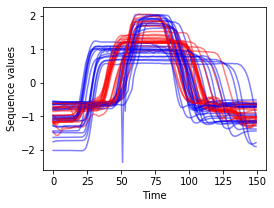

In [55]:
color_dic = {2.0: "blue", 1.0: "red"}
plt.figure(figsize=(4,3))
for i in range(len(ts_labels)):
    plt.plot(np.arange(150), ts_data[i], color=color_dic[ts_labels[i]], alpha=0.5)
plt.ylabel("Sequence values")
plt.xlabel("Time")
plt.show()

Convert it to a single time-series by adding noise between each subsequence:

In [33]:
joined_ts_data = ts_data[0]
joined_ts_labels = [ts_labels[0]]*size
noise_size = math.ceil(size/3)
for i in range(1, len(ts_labels)):
    noise_subseq = []#np.random.normal(0,0.1, noise_size)
    joined_ts_data = np.concatenate((joined_ts_data, noise_subseq, ts_data[i]))
    joined_ts_labels = joined_ts_labels + [-2]*noise_size + [ts_labels[i]]*size
len(joined_ts_data)

7500

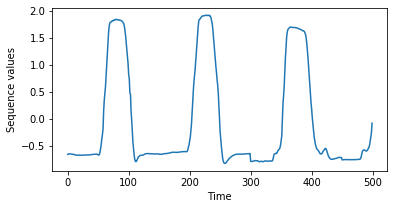

In [48]:
plt.figure(figsize=(6,3))
plt.plot(np.arange(500), joined_ts_data[:500])
plt.ylabel("Sequence values")
plt.xlabel("Time")
plt.show()

Compute the matrix profile with STOMP:

In [35]:
%%time
mp = matrixProfile.stomp(joined_ts_data, size)

CPU times: user 1.88 s, sys: 38.8 ms, total: 1.91 s
Wall time: 1.95 s


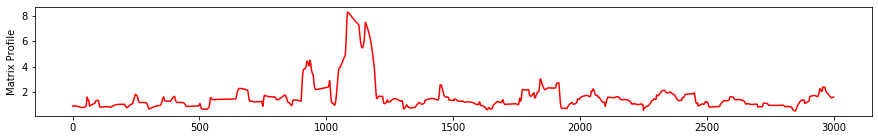

In [36]:
mp_adj = np.append(mp[0],np.zeros(size-1)+np.nan)

plt.figure(figsize=(15,2))
plt.plot(np.arange(3000), mp_adj[:3000], color='red')
plt.ylabel("Matrix Profile")
plt.show()

Extract all the motifs:

In [37]:
%%time
mtfs, motif_d  = motifs.motifs(joined_ts_data, mp, max_motifs=1000)
len(mtfs)

CPU times: user 62.4 ms, sys: 3.97 ms, total: 66.4 ms
Wall time: 72.6 ms


25

Create list of motifs centers:

In [38]:
motif_center_list = []
motif_center_labels = []
for motif in mtfs:
    center_pointers = list(np.arange(motif[0], motif[0]+size))
    motif_center_ts = joined_ts_data[center_pointers]
    motif_center_list.append(motif_center_ts)
    center_labels = [joined_ts_labels[i] for i in center_pointers]
    center_final_label = max(center_labels, key=center_labels.count)
    motif_center_labels.append(center_final_label)

## 3. DTW-SOM training and results

Define the SOM network:

In [41]:
%time
rows = 3
cols = 3
structure = type_conn.grid_four
network = dtw_som.DtwSom(rows, cols, structure)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.11 µs


Train the network:

In [42]:
%%time
network.train(motif_center_list, 50)

Epoch 1 achieved an average quantization error of 1.5916
Epoch 2 achieved an average quantization error of 1.9254
Epoch 3 achieved an average quantization error of 1.9621
Epoch 4 achieved an average quantization error of 1.9481
Epoch 5 achieved an average quantization error of 1.9268
Epoch 6 achieved an average quantization error of 1.8851
Epoch 7 achieved an average quantization error of 1.8552
Epoch 8 achieved an average quantization error of 1.838
Epoch 9 achieved an average quantization error of 1.8229
Epoch 10 achieved an average quantization error of 1.8169
Epoch 11 achieved an average quantization error of 1.7981
Epoch 12 achieved an average quantization error of 1.7544
Epoch 13 achieved an average quantization error of 1.7145
Epoch 14 achieved an average quantization error of 1.6901
Epoch 15 achieved an average quantization error of 1.6723
Epoch 16 achieved an average quantization error of 1.6546
Epoch 17 achieved an average quantization error of 1.641
Epoch 18 achieved an aver

50

Vizualise DTW-SOM U-matrix:

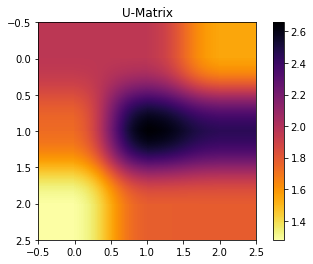

In [43]:
network.show_distance_matrix()

Vizualise the winner matrix:

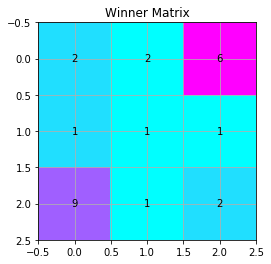

In [44]:
network.show_winner_matrix()

Vizualise the units' sequence values:

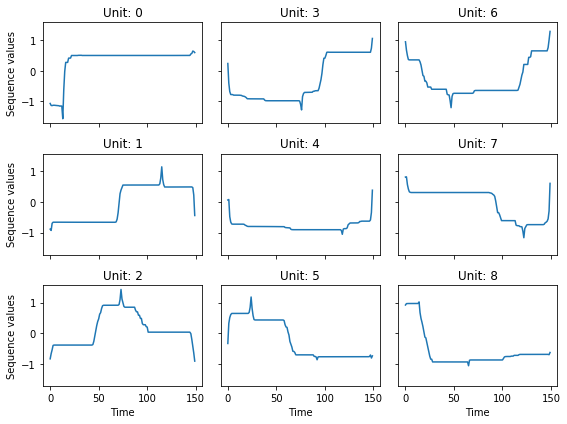

In [57]:
n_neurons = network._size
fig, axs = plt.subplots(3,3,figsize=(8, 6), sharex=True, sharey=True)
for neuron_index in range(n_neurons):
    col = math.floor(neuron_index/3)
    row = neuron_index % 3
    neuron_weights = network._weights[neuron_index]
    axs[row, col].plot(np.arange(len(neuron_weights)), neuron_weights, label=str(neuron_index))
    axs[row, col].set_title("Unit: "+str(neuron_index))
    if col == 0:
        axs[row, col].set_ylabel("Sequence values")
    if row == 2:
        axs[row, col].set_xlabel("Time")
plt.tight_layout()
plt.show()